# Прогноз количества заказов такси

## Описание проекта

Собраны исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

##### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


##### Проверка на упорядоченность

In [3]:
data.index.is_monotonic

True

##### Первый взгляд

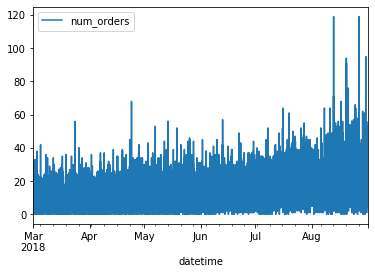

In [4]:
data.plot()

##### Ресэмплирование

In [5]:
data = data.resample('1H').sum()

##### Добавление признаков

In [6]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [7]:
rmse_lr = pd.DataFrame()
k = 0
model = LinearRegression()

for i in range(6, 20):
    for j in range(6, 20):
        k += 1
        data_new = data.copy()
        make_features(data_new, i, j)
        
        train, val_test = train_test_split(data_new, shuffle=False, test_size=0.2)
        val, test = train_test_split(val_test, shuffle=False, test_size=0.5)

        train = train.dropna()

        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_val = val.drop(['num_orders'], axis=1)
        target_val = val['num_orders']
        
        model.fit(features_train, target_train)
        pred_val = model.predict(features_val)

        rmse_lr.loc[k, 'rmse'] = mean_squared_error(target_val, pred_val) ** 0.5
        rmse_lr.loc[k, 'lag'] = i
        rmse_lr.loc[k, 'rolling_window'] = j

In [8]:
rmse_lr.sort_values(by='rmse', ascending=True).head()

,rmse,lag,rolling_window
191,38.579081,19.0,14.0
193,38.597330,19.0,16.0
189,38.597330,19.0,12.0
185,38.597330,19.0,8.0
182,38.597330,18.0,19.0


In [9]:
make_features(data, 19, 14)

##### Разделение на выборки

In [10]:
train, val_test = train_test_split(data_new, shuffle=False, test_size=0.2)
val, test = train_test_split(val_test, shuffle=False, test_size=0.5)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_val = val.drop(['num_orders'], axis=1)
target_val = val['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# 2. Анализ

##### Тренд, сезонность

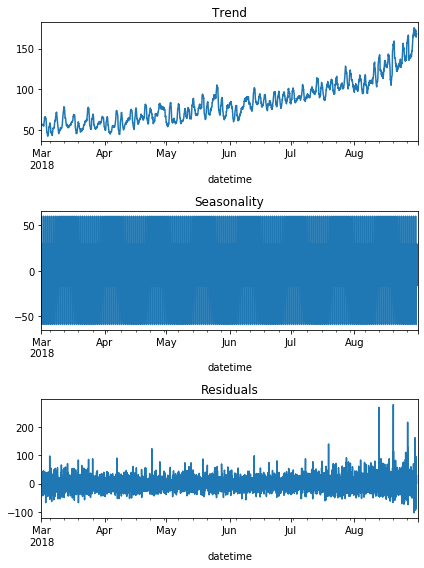

In [11]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

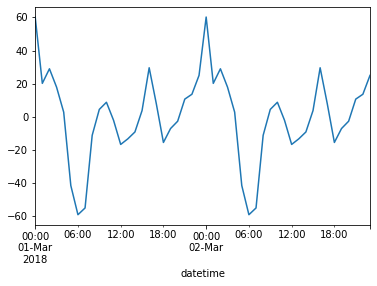

In [12]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()

##### Стационарность

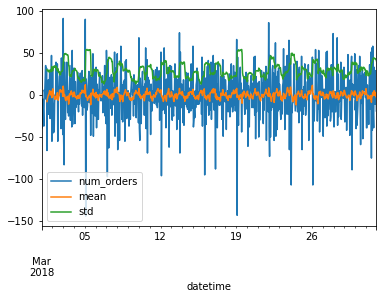

In [13]:
data_1m = data['2018-03'][['num_orders']]
data_1m = data_1m - data_1m.shift()
data_1m['mean'] = data_1m['num_orders'].rolling(12).mean()
data_1m['std'] = data_1m['num_orders'].rolling(12).std()
data_1m.plot()

##### Резюме

+ Присутствует чётко выраженный тренд на увеличение заказов на имеющемся временном интервале. Поскольку есть данные только за полгода, то нельзя точно сказать вызван этот тренд сезонностью (в конце лета люди чаще путешествуют), или же ростом популярности "Чётенького такси".
+ Наблюдается суточная сезонность.
+ Велика случайная составляющая.
+ Ряд не стационарный, поэтому предсказания будут далеки от идеальных.

# 3. Обучение

Конечное обучение буду проводить на объединённой выборке из тренировочной и валидационной выборок.

In [14]:
features_train_full = features_train.append(features_val)
target_train_full = target_train.append(target_val)

##### Линейная регрессия

In [15]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
mean_squared_error(target_val, model_lr.predict(features_val)) ** 0.5

38.59732958467138

In [16]:
model_lr = LinearRegression(normalize=True)
model_lr.fit(features_train, target_train)
mean_squared_error(target_val, model_lr.predict(features_val)) ** 0.5

38.59732958467134

Масштабирование данных не приводит к улучшению результата

##### Случайный лес

In [17]:
rmse_rfr = pd.DataFrame()
k = 0
for i in range(50, 301, 25):
    for j in range(5, 26, 5):
        k += 1
        model = RandomForestRegressor(random_state=42, n_estimators=i, max_depth=j)
        model.fit(features_train, target_train)
        rmse_rfr.loc[k, 'RMSE'] = mean_squared_error(target_val, model.predict(features_val)) ** 0.5
        rmse_rfr.loc[k, 'n_estimators'] = i
        rmse_rfr.loc[k, 'max_depth'] = j

In [18]:
rmse_rfr.sort_values(by='RMSE', ascending=True).head()

,RMSE,n_estimators,max_depth
8,31.073930,75.0,15.0
13,31.099022,100.0,15.0
54,31.159701,300.0,20.0
10,31.161189,75.0,25.0
18,31.162263,125.0,15.0


In [19]:
model_rfr = RandomForestRegressor(n_estimators=75 , max_depth=15 , random_state=42)
model_rfr.fit(features_train_full, target_train_full)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

# 4. Тестирование

In [20]:
columns = ['RMSE']
index = ['Линейная регрессия', 'Случайный лес', 'Константная модель', 'Предсказание предыдущим']
results = pd.DataFrame(index=index, columns= columns)

##### Линейная регрессия

In [21]:
pred_test = model_lr.predict(features_test)
rmse_lr = mean_squared_error(target_test, pred_test) ** 0.5
results.loc['Линейная регрессия', 'RMSE'] = rmse_lr
rmse_lr

55.12238906074766

##### Случайный лес

In [22]:
pred_test = model_rfr.predict(features_test)
rmse_rf = mean_squared_error(target_test, pred_test) ** 0.5
results.loc['Случайный лес', 'RMSE'] = rmse_rf
rmse_rf

44.79447170742094

##### Константная модель

In [23]:
pred_median = np.ones(target_test.shape) * target_train.median()
rmse_const = mean_squared_error(target_test, pred_median) ** 0.5
rmse_const

89.39768286346948

In [24]:
pred_mean = np.ones(target_test.shape) * target_train.mean()
rmse_mean = mean_squared_error(target_test, pred_mean) ** 0.5
results.loc['Константная модель', 'RMSE'] = rmse_mean
rmse_mean

87.58420941118759

##### Предсказание предыдущим значением

In [25]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_prev = mean_squared_error(target_test, pred_previous) ** 0.5
results.loc['Предсказание предыдущим', 'RMSE'] = rmse_prev
rmse_prev

58.88016052260236

## Итоги

In [26]:
results.sort_values(by='RMSE')

,RMSE
Случайный лес,44.7945
Линейная регрессия,55.1224
Предсказание предыдущим,58.8802
Константная модель,87.5842


+ Поскольку исходный временной ряд обладает суточной сезонностью, нужно в признаки добавлять "час"
+ Проверенные модели превзошли константную модель
+ Модель случайного леса показала удовлетворительный результат